In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint
import tensorflow 
import keras  
import os
import glob 
from skimage import io 
import random 

import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout,TimeDistributed
from tensorflow.keras.layers import TimeDistributed

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D,Activation

In [2]:
dataset_path = r'C:\Users\pc\OneDrive\Desktop\nit rkl\Alzheimer_s Dataset - Copy\train'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']
IMG_SIZE = 224
IMAGE_SIZE = [224, 224]
DIM = (IMG_SIZE, IMG_SIZE)

# apply glob module to retrieve files/pathnames  

mri_path = os.path.join(dataset_path, CLASSES[1], '*')
mri_path = glob.glob(mri_path)

In [3]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=dataset_path, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


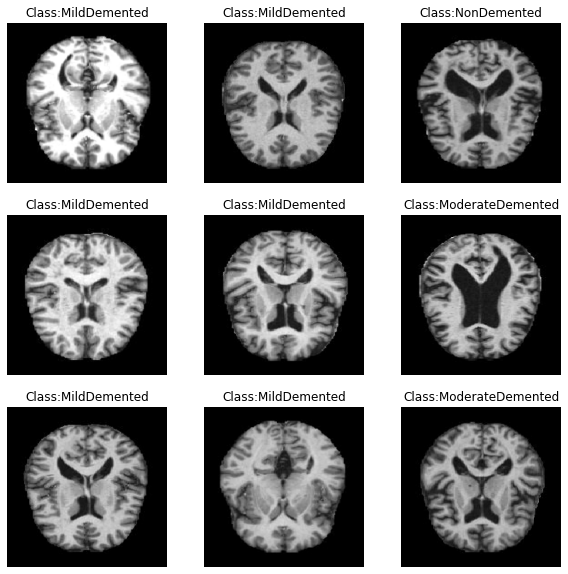

In [4]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [5]:

train_data, train_labels = train_data_gen.next()

In [6]:
print(train_data.shape, train_labels.shape)

(6400, 224, 224, 3) (6400, 4)


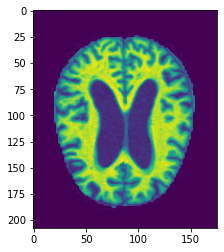

In [7]:
image = io.imread(mri_path[34])  

# plotting the original image
i, (im1) = plt.subplots(1)
i.set_figwidth(15)
im1.imshow(image)

In [8]:
# importing libraries
import tensorflow 
import keras  
import os
import glob 
from skimage import io 
import random 
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
import skimage.color as scc

C:\Users\pc\AppData\Local\Temp/ipykernel_5276/2802754522.py:2: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  gray_image = scc.rgb2gray(image)


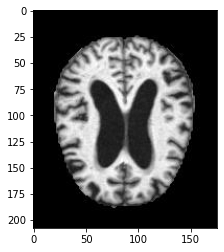

In [9]:
#normalization
gray_image = scc.rgb2gray(image)
plt.imshow(gray_image, cmap = 'gray')

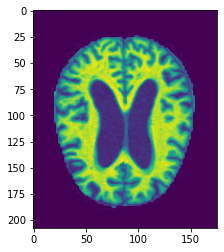

In [10]:

norm_image = (gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))
plt.imshow(norm_image)

In [11]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

In [13]:
# OVER SAMPLING
# - validation data
val_data, val_labels = sm.fit_resample(val_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), val_labels)

val_data = val_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(val_data.shape, val_labels.shape)

(2096, 224, 224, 3) (2096, 4)


In [ ]:
def conv_block(filters, act='relu',i=0):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same', name=f'conv2d_p{i}'))
    block.add(Conv2D(filters, 3, activation=act, padding='same', name=f'conv2d_pp{i}'))
    block.add(Conv2D(filters, 3, activation=act, padding='same', name=f'conv2d_pp{i}'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [26]:
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [30]:
#Defining other parameters for our CNN model

model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]


model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

NameError: name 'construct_model' is not defined

In [25]:
EPOCHS = 5

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/5
255/255 [==============================] - 1481s 6s/step - loss: 1.2315 - acc: 0.4780 - auc: 0.7455 - f1_score: 0.4722 - val_loss: 36.4453 - val_acc: 0.2500 - val_auc: 0.4999 - val_f1_score: 0.1000
Epoch 2/5
255/255 [==============================] - 1537s 6s/step - loss: 0.8513 - acc: 0.6129 - auc: 0.8674 - f1_score: 0.6051 - val_loss: 1.5401 - val_acc: 0.4499 - val_auc: 0.7481 - val_f1_score: 0.3781
Epoch 3/5
255/255 [==============================] - 1553s 6s/step - loss: 0.6728 - acc: 0.6836 - auc: 0.9162 - f1_score: 0.6762 - val_loss: 0.5930 - val_acc: 0.7371 - val_auc: 0.9378 - val_f1_score: 0.7393
Epoch 4/5
255/255 [==============================] - 1569s 6s/step - loss: 0.5718 - acc: 0.7469 - auc: 0.9402 - f1_score: 0.7452 - val_loss: 4.3377 - val_acc: 0.2781 - val_auc: 0.5951 - val_f1_score: 0.1555
Epoch 5/5
255/255 [==============================] - 1555s 6s/step - loss: 0.4989 - acc: 0.7793 - auc: 0.9542 - f1_score: 0.7785 - val_loss: 0.6766 - val_acc: 0.6789 - val

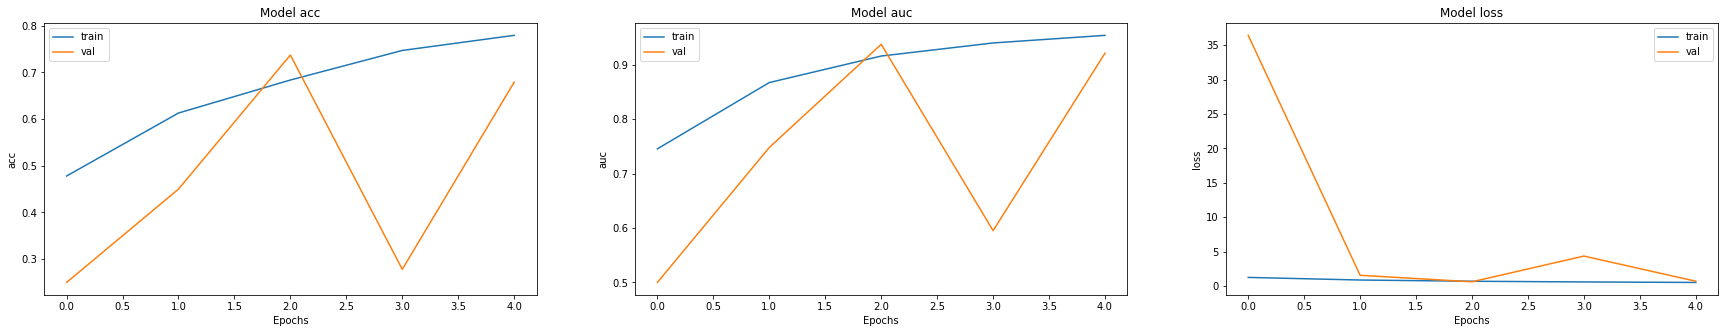

In [26]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [27]:
#Evaluating the model on the data

train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

40/40 [==============================] - 59s 1s/step - loss: 1.0755 - acc: 0.4703 - auc: 0.7965 - f1_score: 0.5817
Training Accuracy: 72.38%
Validation Accuracy: 67.89%
Testing Accuracy: 47.03%


In [31]:
base_model =  tf.keras.applications.InceptionResNetV2(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

In [17]:
from tensorflow.python.keras.layers import LSTM


In [15]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [42]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(TimeDistributed(LSTM(32, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Flatten())
#model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(TimeDistributed(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))
# Model Summary



In [47]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [48]:
#Defining other parameters for our CNN model

model = model

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]


model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 time_distributed_3 (TimeDis  (None, 5, 5, 64)         409856    
 tributed)                                                       
                                                                 
 conv2d_623 (Conv2D)         (None, 5, 5, 64)          36928     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 2, 2, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_624 (Conv2D)         (None, 2, 2, 128)         73856     
                                                     

In [27]:
EPOCHS = 10  

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels),batch_size=32, callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/10
255/255 [==============================] - 1243s 5s/step - loss: 0.9109 - acc: 0.5809 - auc: 0.8514 - f1_score: 0.5817 - val_loss: 0.7377 - val_acc: 0.6784 - val_auc: 0.9135 - val_f1_score: 0.6850
Epoch 2/10
255/255 [==============================] - 1246s 5s/step - loss: 0.7668 - acc: 0.6524 - auc: 0.8954 - f1_score: 0.6533 - val_loss: 0.6564 - val_acc: 0.6975 - val_auc: 0.9255 - val_f1_score: 0.7055
Epoch 3/10
255/255 [==============================] - 1254s 5s/step - loss: 0.6720 - acc: 0.6974 - auc: 0.9197 - f1_score: 0.6994 - val_loss: 0.6061 - val_acc: 0.7238 - val_auc: 0.9340 - val_f1_score: 0.7305
Epoch 4/10
255/255 [==============================] - 30707s 121s/step - loss: 0.6341 - acc: 0.7197 - auc: 0.9286 - f1_score: 0.7221 - val_loss: 0.5858 - val_acc: 0.7486 - val_auc: 0.9403 - val_f1_score: 0.7548
Epoch 5/10
255/255 [==============================] - 1229s 5s/step - loss: 0.5871 - acc: 0.7360 - auc: 0.9380 - f1_score: 0.7380 - val_loss: 0.5817 - val_acc: 0.745

In [74]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') >= 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [75]:
#Defining other parameters for our CNN model

model = model

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]


model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 conv2d_262 (Conv2D)         (None, 5, 5, 64)          884800    
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 2, 2, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_263 (Conv2D)         (None, 2, 2, 128)         73856     
                                                                 
 conv2d_264 (Conv2D)         (None, 2, 2, 128)         147584    
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 1, 1, 128)      

In [67]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 conv2d_250 (Conv2D)         (None, 5, 5, 64)          884800    
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 2, 2, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_251 (Conv2D)         (None, 2, 2, 128)         73856     
                                                                 
 conv2d_252 (Conv2D)         (None, 2, 2, 128)         147584    
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 1, 1, 128)      

In [ ]:
EPOCHS = 12  

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels),batch_size=32, callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/12
178/255 [===================>..........] - ETA: 26:03 - loss: 1.3869 - acc: 0.2575 - auc: 0.5041 - f1_score: 0.1686

In [39]:
from tensorflow.keras.layers import Bidirectional, MaxPooling2D, TimeDistributed
from tensorflow.keras.layers import LSTM, GRU

 
bidLayer = Bidirectional(LSTM(10, return_sequences=True), input_shape=(224,3))

In [45]:
EPOCHS = 12  

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels),batch_size=32, callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/12
128/128 [==============================] - 2688s 21s/step - loss: 1.2483 - acc: 0.4453 - auc: 0.7157 - f1_score: 0.2560 - val_loss: 1.0771 - val_acc: 0.4902 - val_auc: 0.7887 - val_f1_score: 0.2358
Epoch 2/12
 78/128 [=================>............] - ETA: 5:16:29 - loss: 1.1021 - acc: 0.4768 - auc: 0.7725 - f1_score: 0.2440

KeyboardInterrupt: 

In [52]:
model = Sequential()
model.add(base_model)
model.add(TimeDistributed(LSTM(64, return_sequences=True)))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(1,1),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(1,1),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(1,1),strides=(2,2)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(1,1),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4, activation="softmax"))

In [49]:
EPOCHS = 10  

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels),batch_size=32, callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/10
128/128 [==============================] - 2718s 21s/step - loss: 1.0675 - acc: 0.4817 - auc: 0.7720 - f1_score: 0.2067 - val_loss: 1.0463 - val_acc: 0.5117 - val_auc: 0.7871 - val_f1_score: 0.1693
Epoch 2/10
128/128 [==============================] - 2651s 21s/step - loss: 1.0512 - acc: 0.4963 - auc: 0.7767 - f1_score: 0.1659 - val_loss: 1.0223 - val_acc: 0.5117 - val_auc: 0.7871 - val_f1_score: 0.1693
Epoch 3/10
128/128 [==============================] - 2722s 21s/step - loss: 1.0474 - acc: 0.4963 - auc: 0.7757 - f1_score: 0.1659 - val_loss: 1.0192 - val_acc: 0.5117 - val_auc: 0.7871 - val_f1_score: 0.1693
Epoch 4/10
 14/128 [==>...........................] - ETA: 37:55 - loss: 1.0330 - acc: 0.5134 - auc: 0.7794 - f1_score: 0.1696

KeyboardInterrupt: 

In [51]:
base_model =  tf.keras.applications.Xception(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

In [ ]:
model = Sequential()
model.add(base_model)
model.add(TimeDistributed(LSTM(64, return_sequences=True)))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(TimeDistributed(LSTM(64, return_sequences=True)))

model.add(Flatten())
model.add(Dense(units=4, activation="softmax"))
